In [31]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import model_selection
import json

In [ ]:
with open('./statics/features.json', 'r') as f:
    features = json.load(f)

continuous_features = features.get('continuous_features')
categorical_features = features.get('categorical_features')

In [18]:
data = pd.read_csv('./data/display_row_data_sample_10K.csv') # 原始数据
data_model = pd.read_csv('./data/encode_row_data_sample_10K.csv') # 类别特征处理为int值

In [19]:
data.head(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,PREDICT
0,100011,0,0,112500.0,1019610.0,33826.5,913500.0,0.018634,-20099,365243,...,0,0,1,0,0,-2508.0,0.0,0.0,90744.3,0.041745
1,100023,0,1,90000.0,544491.0,17563.5,454500.0,0.015221,-11348,-2038,...,1,1,1,1,0,-2624.0,0.0,0.0,22500.0,0.212928


由于机器性能限制，同时为了加速训练，因此只选择部分特征

In [4]:
categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE']
continuous_features = ['DAYS_BIRTH', 'COMMONAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                       'AMT_REQ_CREDIT_BUREAU_DAY', 'DAYS_CREDIT', 
                       'CREDIT_DAY_OVERDUE', 'DAYS_REGISTRATION', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM','AMT_ANNUITY',
                      'YEARS_BUILD_MODE','OWN_CAR_AGE','ELEVATORS_AVG','NONLIVINGAREA_AVG','CNT_FAM_MEMBERS']

In [5]:
use_cols = categorical_features+continuous_features

In [21]:
# 划分训练集测试集
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(data_model[use_cols],
                                                                      data_model['TARGET'].values,
                                                                      test_size=0.20,
                                                                      random_state=10,
                                                                      stratify=data_model.TARGET)

In [22]:
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.01,
          'verbose': -1}

In [23]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

model = lgb.train(params=params,
                   train_set=lgb_train,
                   num_boost_round=5000,
                   valid_sets=[lgb_train, lgb_eval],
                   early_stopping_rounds=1000,
                   verbose_eval=100,
                   categorical_feature=categorical_features) # 指定类别特征

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE']
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.832182	valid_1's auc: 0.642622
[200]	training's auc: 0.892259	valid_1's auc: 0.644789
[300]	training's auc: 0.932912	valid_1's auc: 0.648254
[400]	training's auc: 0.956586	valid_1's auc: 0.646556
[500]	training's auc: 0.969669	valid_1's auc: 0.644897
[600]	training's auc: 0.978032	valid_1's auc: 0.640906
[700]	training's auc: 0.983395	valid_1's auc: 0.6384
[800]	training's auc: 0.986985	valid_1's auc: 0.636774
[900]	training's auc: 0.989809	valid_1's auc: 0.634494
[1000]	training's auc: 0.992356	valid_1's auc: 0.632862
[1100]	training's auc: 0.994251	valid_1's auc: 0.628497
[1200]	training's auc: 0.995416	valid_1's auc: 0.626095
[1300]	training's auc: 0.996542	valid_1's auc: 0.624046
Early stopping, best iteration is:
[304]	training's auc: 0.934233	valid_1's auc: 0.648645


In [24]:
model.save_model('./model.lgb') # 保存模型文件

In [6]:
# model = lgb.Booster(model_file='./model.lgb') #加载特征文件

In [25]:
data_model['PREDICT'] = model.predict(data_model[use_cols])
data['PREDICT'] = model.predict(data_model[use_cols])

In [26]:
# lgb自带的特征重要性
feat_imp = pd.DataFrame(dict(columns=use_cols, feature_importances=model.feature_importance(importance_type='gain')))
feat_imp.sort_values(by=["feature_importances"], axis=0, ascending=False)

,columns,feature_importances
5,DAYS_BIRTH,10413.822997
11,DAYS_REGISTRATION,7982.184250
9,DAYS_CREDIT,7727.617940
13,AMT_CREDIT_SUM,6976.549546
14,AMT_ANNUITY,6568.035098
16,OWN_CAR_AGE,3408.429869
15,YEARS_BUILD_MODE,3316.067009
6,COMMONAREA_MODE,3110.687169
18,NONLIVINGAREA_AVG,2693.009583
0,CODE_GENDER,1888.308838


In [9]:
import matplotlib.pyplot as plt

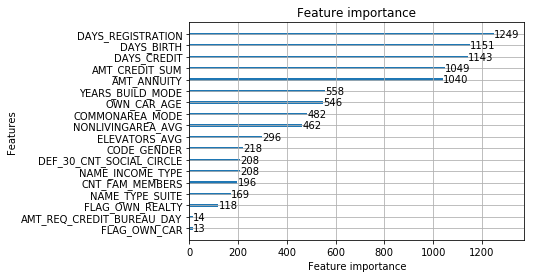

In [10]:
lgb.plot_importance(booster=model)
plt.show()

## SHAP VALUE

In [27]:
import shap
explainer = shap.TreeExplainer(model) # 初始化解释器

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [28]:
shap.initjs() # 载入JS

In [29]:
shap_values = explainer.shap_values(data_model[use_cols]) # 计算SHAP值

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP对于xgboost和lightgbm取的是对数几率转换，可以做一个验证：

In [32]:
explainer.expected_value[1],  np.log(data['PREDICT']/ (1 - data['PREDICT'])).mean()

(-2.583467142969475, -2.583400390403734)

--------------------

选择3个样本， 
即标签为0预测为坏用户概率极低（低风险样本），  
标签为1预测为坏用户概率极高(高风险样本)，  
标签为1预测为坏用户概率极低（模型未能识别样本）

In [34]:
data[use_cols+['TARGET','PREDICT']].iloc[3860,:] # 低风险样本

CODE_GENDER                              F
FLAG_OWN_CAR                             Y
FLAG_OWN_REALTY                          Y
NAME_TYPE_SUITE              Unaccompanied
NAME_INCOME_TYPE                   Working
DAYS_BIRTH                          -19046
COMMONAREA_MODE                     0.0686
DEF_30_CNT_SOCIAL_CIRCLE                 0
AMT_REQ_CREDIT_BUREAU_DAY                0
DAYS_CREDIT                           -847
CREDIT_DAY_OVERDUE                       0
DAYS_REGISTRATION                    -8310
CNT_CREDIT_PROLONG                       0
AMT_CREDIT_SUM                       45000
AMT_ANNUITY                          12105
YEARS_BUILD_MODE                    0.7583
OWN_CAR_AGE                             14
ELEVATORS_AVG                         0.28
NONLIVINGAREA_AVG                   0.0129
CNT_FAM_MEMBERS                          1
TARGET                                   0
PREDICT                          0.0136315
Name: 3860, dtype: object

In [35]:
data[use_cols+['TARGET','PREDICT']].iloc[6578,:] # 高风险样本

CODE_GENDER                              M
FLAG_OWN_CAR                             N
FLAG_OWN_REALTY                          N
NAME_TYPE_SUITE              Unaccompanied
NAME_INCOME_TYPE                   Working
DAYS_BIRTH                          -16500
COMMONAREA_MODE                     0.0019
DEF_30_CNT_SOCIAL_CIRCLE                 3
AMT_REQ_CREDIT_BUREAU_DAY                0
DAYS_CREDIT                          -1087
CREDIT_DAY_OVERDUE                       0
DAYS_REGISTRATION                    -8989
CNT_CREDIT_PROLONG                       0
AMT_CREDIT_SUM                     16564.5
AMT_ANNUITY                        13639.5
YEARS_BUILD_MODE                    0.6537
OWN_CAR_AGE                            NaN
ELEVATORS_AVG                            0
NONLIVINGAREA_AVG                    0.005
CNT_FAM_MEMBERS                          2
TARGET                                   1
PREDICT                           0.625019
Name: 6578, dtype: object

In [36]:
data[use_cols+['TARGET','PREDICT']].iloc[1828,:] # 未识别样本

CODE_GENDER                          F
FLAG_OWN_CAR                         Y
FLAG_OWN_REALTY                      Y
NAME_TYPE_SUITE                 Family
NAME_INCOME_TYPE               Working
DAYS_BIRTH                      -21233
COMMONAREA_MODE                 0.0835
DEF_30_CNT_SOCIAL_CIRCLE             0
AMT_REQ_CREDIT_BUREAU_DAY            0
DAYS_CREDIT                       -579
CREDIT_DAY_OVERDUE                   0
DAYS_REGISTRATION                -7318
CNT_CREDIT_PROLONG                   0
AMT_CREDIT_SUM                       0
AMT_ANNUITY                      46044
YEARS_BUILD_MODE                0.7779
OWN_CAR_AGE                          4
ELEVATORS_AVG                     0.52
NONLIVINGAREA_AVG               0.0055
CNT_FAM_MEMBERS                      2
TARGET                               1
PREDICT                      0.0185526
Name: 1828, dtype: object

In [37]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3860,:], data[use_cols].iloc[3860,:]) # 低风险样本

### 解释：蓝色为降低，红色为增加，上图output value为-4.28，低于base value,即该样本为坏用户概率低于平均水平，而这一值是主要由DAYS_BIRTH等贡献。

In [38]:
shap.force_plot(explainer.expected_value[1], shap_values[1][6578,:], data[use_cols].iloc[6578,:]) # 高风险样本

In [39]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1828,:], data[use_cols].iloc[1828,:]) # 未识别样本

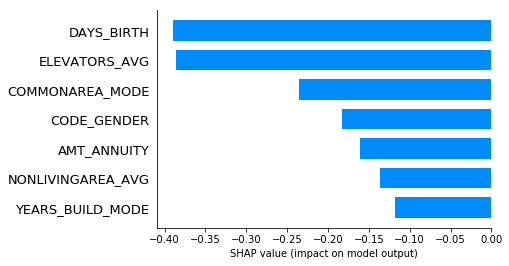

In [40]:
shap.bar_plot(shap_values=shap_values[1][3860,:],feature_names=use_cols) # 样本特征shap值排序

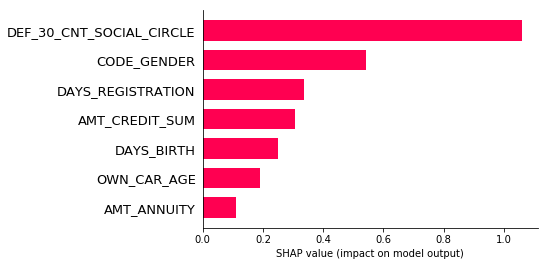

In [41]:
shap.bar_plot(shap_values=shap_values[1][6578,:],feature_names=use_cols) # 样本特征shap值排序

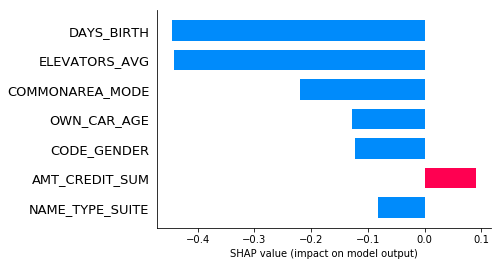

In [42]:
shap.bar_plot(shap_values=shap_values[1][1828,:],feature_names=use_cols) # 样本特征shap值排序

### 解释：由上面三图可以看到，未识别样本的各特征贡献上与低风险样本类似，这也是造成模型误判的原因。

-------------------------

### 单特征与预测结果直接的关系分析

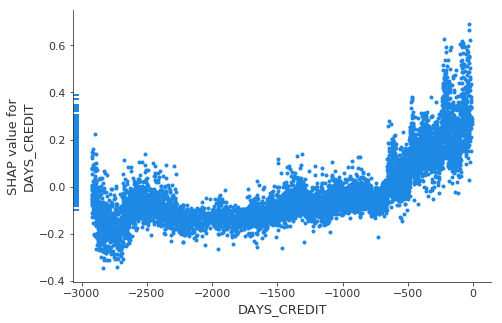

In [44]:
shap.dependence_plot('DAYS_CREDIT', shap_values[1], data_model[use_cols], display_features=data[use_cols],interaction_index=None)

### 如上图，横坐标是特征的值，纵坐标是对应的shap值，整体趋势也是随着days_credit增大，shap值增大。

------------------------

### 特征交互作用与预测结果关系分析

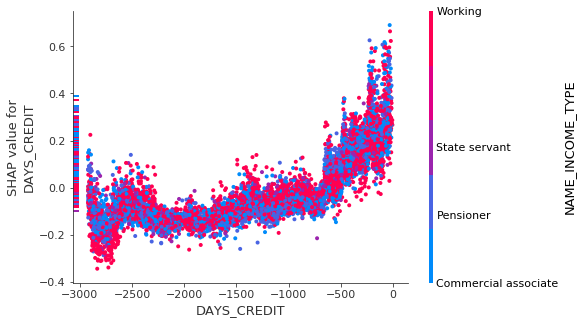

In [45]:
shap.dependence_plot('DAYS_CREDIT', shap_values[1], data_model[use_cols], display_features=data[use_cols],interaction_index='NAME_INCOME_TYPE')

### 如上图，主体仍然是DAYS_CREDIT的分布，但是加入了NAME_INCOME_TYPE特征，右坐标轴代表不同的NAME_INCOME_TYPE的颜色，可以看到，在不同的DAYS_CREDIT区间上，由不同的NAME_INCOME_TYPE带来的shap值也不同，如在较小的DAYS_CREDIT上，NAME_INCOME_TYPE为working有更低的shap值，而在中间的的DAYS_CREDIT上，working有更高的shap值。

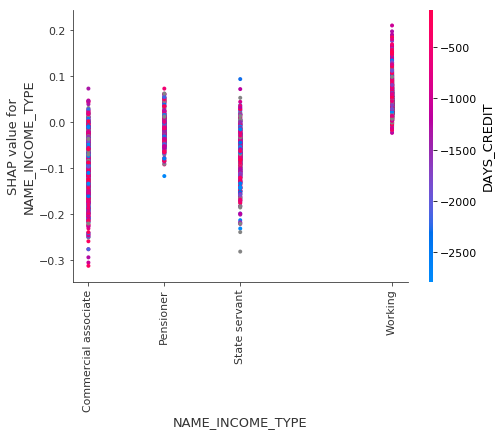

In [46]:
shap.dependence_plot('NAME_INCOME_TYPE', shap_values[1], data_model[use_cols], display_features=data[use_cols],interaction_index='DAYS_CREDIT')

## 两种特征重要性

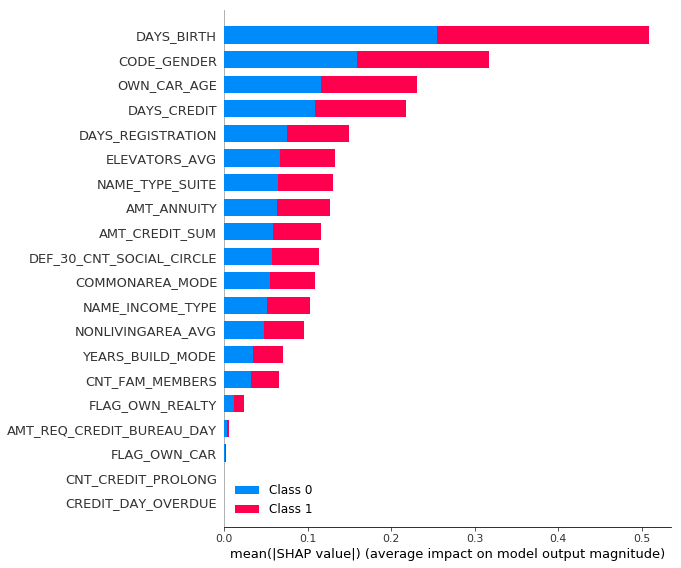

In [49]:
shap.summary_plot(shap_values, data[use_cols])

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less


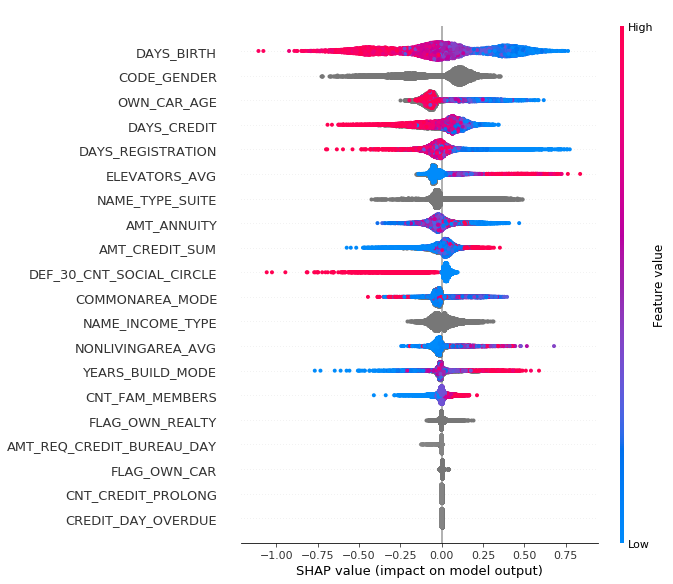

In [48]:
shap.summary_plot(shap_values[0], data[use_cols])

### 交互图

In [50]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:200,:], data[use_cols].iloc[:200,:])